In [220]:
# %pip install nibabel
# %pip install nilearn

In [221]:
import numpy as np
import nibabel as nib
import nilearn 
import matplotlib.pyplot as plt
import os
from os.path import join as opj
import pandas as pd
import seaborn as sns
import glob
from nilearn import plotting
from nilearn.image import *
import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
from nilearn.plotting import plot_img, plot_epi
from nilearn.maskers import NiftiMasker
from sklearn.preprocessing import StandardScaler
import wandb
import pickle

In [222]:
wandb.login()


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

## 0. Load the fMRI data

In [223]:
# Define the base path where the BOLD5000 data is stored
base_path = "/home/matteo/data/BOLD5000"

# Define the path to the stimuli data
stimuli_path = opj(base_path, "stimuli", "BOLD5000_Stimuli")

# Define the subject identifier
subj = "CSI4"

load_data = False # in case some data are already processed and saved, set this to True to avoid reprocessing

# Get all .nii.gz files in the base path
data_path = glob.glob(opj(base_path, "*.nii.gz"))

# Filter the data_path list to include only files related to the specified subject
data_path = [x for x in data_path if subj in x]

# Further filter the data_path list to include only files that contain "TYPED" in their name
data_path = [x for x in data_path if "TYPED" in x]

target_dir = f"/home/matteo/storage/brain_tuning/{subj}"
os.makedirs(target_dir,exist_ok=True)


config = {"subj":subj, "model":"encoding"}
wandb.init(project="brain_tuning",config=config )

Baseline Top-1 Accuracy,▁
Baseline Top-5 Accuracy,▁
Identification Accuracy,▁
Top-1 Accuracy,▁
Top-1 Accuracy over Baseline,▁
Top-5 Accuracy,▁
Top-5 Accuracy over Baseline,▁
Baseline Top-1 Accuracy,0.02635
Baseline Top-5 Accuracy,0.2635
Identification Accuracy,0.91569
Top-1 Accuracy,3.42205


In [224]:
# Initialize an empty list to store the shapes of the fMRI data
shapes = []

# Iterate over each file path in the data_path list
for x in data_path:
    # Load the fMRI data from the file and append its shape to the shapes list
    shapes.append(nib.load(x).shape)

# shapes now contains the dimensions of each fMRI data file

# Print the shapes of the fMRI data
print(shapes)

[(70, 89, 70, 370), (70, 89, 70, 333), (70, 89, 70, 333), (70, 89, 70, 370), (70, 89, 70, 333), (70, 89, 70, 333), (70, 89, 70, 333), (70, 89, 70, 333), (70, 89, 70, 370)]


In [225]:
# Check stimuli presentation list

# Define the path to the stimuli presentation lists for the specified subject
stimuli_presentation_list_path = opj(stimuli_path, "Stimuli_Presentation_Lists", subj)

# Format the session number as a two-digit string
sess = str(1).zfill(2)

# Define the path to the stimuli presentation list for the specified session
stimuli_sess_path = opj(stimuli_presentation_list_path, f"{subj}_sess{sess}")

# Get a sorted list of all .txt files in the stimuli session path
files = sorted(glob.glob(opj(stimuli_sess_path, "*.txt")))

# Print the first 10 files in the list
print(files[:10])

['/home/matteo/data/BOLD5000/stimuli/BOLD5000_Stimuli/Stimuli_Presentation_Lists/CSI4/CSI4_sess01/CSI4_sess01_run01.txt', '/home/matteo/data/BOLD5000/stimuli/BOLD5000_Stimuli/Stimuli_Presentation_Lists/CSI4/CSI4_sess01/CSI4_sess01_run02.txt', '/home/matteo/data/BOLD5000/stimuli/BOLD5000_Stimuli/Stimuli_Presentation_Lists/CSI4/CSI4_sess01/CSI4_sess01_run03.txt', '/home/matteo/data/BOLD5000/stimuli/BOLD5000_Stimuli/Stimuli_Presentation_Lists/CSI4/CSI4_sess01/CSI4_sess01_run04.txt', '/home/matteo/data/BOLD5000/stimuli/BOLD5000_Stimuli/Stimuli_Presentation_Lists/CSI4/CSI4_sess01/CSI4_sess01_run05.txt', '/home/matteo/data/BOLD5000/stimuli/BOLD5000_Stimuli/Stimuli_Presentation_Lists/CSI4/CSI4_sess01/CSI4_sess01_run06.txt', '/home/matteo/data/BOLD5000/stimuli/BOLD5000_Stimuli/Stimuli_Presentation_Lists/CSI4/CSI4_sess01/CSI4_sess01_run07.txt', '/home/matteo/data/BOLD5000/stimuli/BOLD5000_Stimuli/Stimuli_Presentation_Lists/CSI4/CSI4_sess01/CSI4_sess01_run08.txt', '/home/matteo/data/BOLD5000/sti

In [226]:
# read first element of files and convert into a list
"""
Reads the first element of each line from text files in specified directories and appends them to a list.

This script iterates over session directories, reads text files within those directories, 
and extracts the first element of each line in the files. The extracted elements are stored in the `image_names` list.
"""

if not load_data:
    image_names=[]

    for j in range(1,16):
        sess=str(j).zfill(2)


        stimuli_sess_path=opj(stimuli_presentation_list_path,f"{subj}_sess{sess}")
        files=sorted(glob.glob(opj(stimuli_sess_path,"*.txt")))

        for i in range(len(files)):
            with open(files[i]) as f:
                for line in f:
                    image_names.append(line.split()[0])

    # Print the first 10 elements of the image_names list
    print(image_names[:10])


['COCO_train2014_000000292845.jpg', 'COCO_train2014_000000081476.jpg', 'n04209133_8326.JPEG', 'banquetHall2.jpg', 'n02002556_6108.JPEG', 'n02101388_6823.JPEG', 'courthouse4.jpg', 'COCO_train2014_000000576727.jpg', 'clothingstore5.jpg', 'sidewalk2.jpg']


In [227]:
if load_data:
    fmri_masked_data = np.load(opj(target_dir,f"fmri_masked_data_{subj}.npy"))
    image_names = np.load(opj(target_dir,f"image_names_{subj}.npy"))


In [228]:
if not load_data:
    # load the fMRI data
    fmri_data=[nib.load(i) for i in data_path]

    #compute some fMRI mean image
    img_mean=mean_img(fmri_data[0])

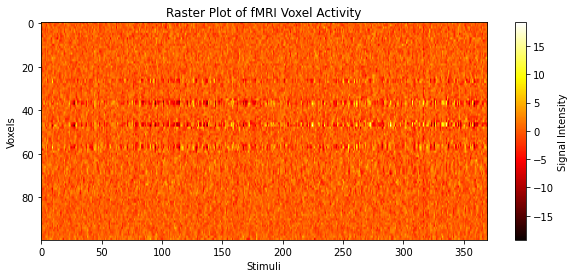

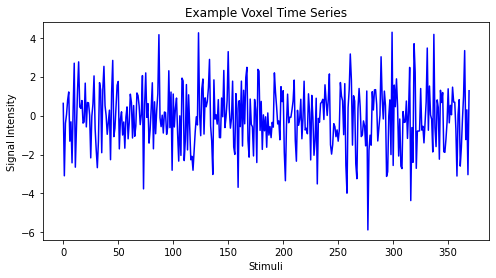

In [229]:
if not load_data:
    # Raster plot of voxel activity across time (example voxel region)
    voxel_data = fmri_data[0].get_fdata()  # Extract data from the first fMRI file as an example
    time_series = voxel_data[30:40, 30:40, 20, :]  # Example region and voxel time series
    plt.figure(figsize=(10, 4))
    plt.imshow(time_series.reshape(-1, time_series.shape[-1]), aspect="auto", cmap="hot")
    plt.colorbar(label="Signal Intensity")
    plt.title("Raster Plot of fMRI Voxel Activity")
    plt.xlabel("Stimuli")
    plt.ylabel("Voxels")
    plt.show()

    # Example time series of a single voxel (for a clearer representation)
    single_voxel_time_series = voxel_data[32, 32, 20, :]  # Select a specific voxel
    plt.figure(figsize=(8, 4))
    plt.plot(single_voxel_time_series, color="b")
    plt.title("Example Voxel Time Series")
    plt.xlabel("Stimuli")
    plt.ylabel("Signal Intensity")
    plt.show()

## Find a ROI responsive for images


In [230]:
if not load_data:
    masker = NiftiMasker(mask_strategy="background")
    masker.fit(img_mean)
    report = masker.generate_report()
    report

        # Save the masker object with pickle
    with open(f'{target_dir}/masker_object.pkl', 'wb') as f:
        pickle.dump(masker, f)

    # Extract and save the mask as a NIfTI file
    mask_nifti = masker.mask_img_
    mask_nifti.to_filename(f'{target_dir}/mask_image.nii.gz')

/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


In [231]:
if not load_data:
    #remove background for each image
    fmri_masked_data=[masker.transform(i) for i in tqdm.tqdm(fmri_data)]
    #concatenate everything in a single array
    fmri_masked_data = np.concatenate(fmri_masked_data,0)

100%|██████████| 9/9 [01:22<00:00,  9.15s/it]


In [232]:
## Save data
if not load_data:


    np.save(opj(target_dir,f"fmri_masked_data_{subj}.npy"),fmri_masked_data)
    np.save(opj(target_dir,f"image_names_{subj}.npy"),np.array(image_names))


## Load the images

In [233]:
all_imgs=[]

#load the images
for i in tqdm.trange(len(image_names)):
    
    tmp_img_name=image_names[i].replace("rep_","")
    if "COCO" in image_names[i]:
        dataset_img_dir="COCO"
        
    elif "n"==tmp_img_name[0:1] and ".JPEG" in tmp_img_name:
        dataset_img_dir="ImageNet"
    else:
        dataset_img_dir="Scene"


    path=opj(stimuli_path,"Scene_Stimuli","Presented_Stimuli",dataset_img_dir,tmp_img_name)
    img=Image.open(path).convert("RGB").resize((375,375))
    all_imgs.append(img)

100%|██████████| 3108/3108 [00:09<00:00, 338.42it/s]


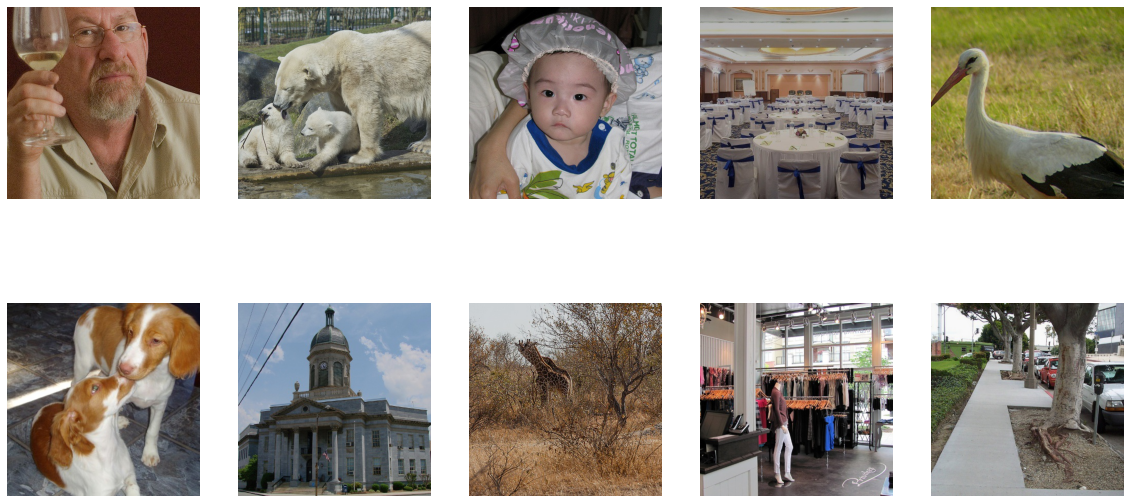

In [234]:
## Show the first 10 images
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(all_imgs[i])
    plt.axis("off")

## Split the data into training and testing sets

In [235]:
## split fMRI and images into train test and validation sets
fmri_train, fmri_test, img_train, img_test = train_test_split(fmri_masked_data, all_imgs, test_size=0.15, random_state=42)

fmri_train, fmri_val, img_train, img_val = train_test_split(fmri_train, img_train, test_size=0.15, random_state=42)

In [236]:
## check the shapes of the data
print("Training data shapes:")
print("fMRI training data shape:", fmri_train.shape)
print("Image training data shape:", len(img_train))
print("\nValidation data shapes:")
print("fMRI validation data shape:", fmri_val.shape)
print("Image validation data shape:", len(img_val))
print("\nTesting data shapes:")

print("fMRI testing data shape:", fmri_test.shape)
print("Image testing data shape:", len(img_test))

Training data shapes:
fMRI training data shape: (2244, 191478)
Image training data shape: 2244

Validation data shapes:
fMRI validation data shape: (397, 191478)
Image validation data shape: 397

Testing data shapes:
fMRI testing data shape: (467, 191478)
Image testing data shape: 467


## Standardize the data 

In [237]:
## print mean and std of the fMRI data
print("Mean  and of the fMRI training data:", fmri_train.mean(), fmri_train.std())
print("Mean  and of the fMRI validation data:", fmri_val.mean(), fmri_val.std())
print("Mean  and of the fMRI testing data:", fmri_test.mean(), fmri_test.std())

## Standardize the fMRI data
scaler = StandardScaler()
fmri_train = scaler.fit_transform(fmri_train)
fmri_val = scaler.transform(fmri_val)
fmri_test = scaler.transform(fmri_test)

## print mean and std of the fMRI data after standardization
print("Mean  and of the fMRI training data after standardization:", fmri_train.mean(), fmri_train.std())
print("Mean  and of the fMRI validation data after standardization:", fmri_val.mean(), fmri_val.std())
print("Mean  and of the fMRI testing data after standardization:", fmri_test.mean(), fmri_test.std())


Mean  and of the fMRI training data: 0.26255664 413.569
Mean  and of the fMRI validation data: 0.28092098 107.50483
Mean  and of the fMRI testing data: 0.31604356 162.97351
Mean  and of the fMRI training data after standardization: -1.283129e-09 0.99999994
Mean  and of the fMRI validation data after standardization: -0.0038206328 0.9972468
Mean  and of the fMRI testing data after standardization: 0.0064645065 1.0105705


In [238]:
if not load_data:
    ## Save the training, validation, and testing data
    np.save(opj(target_dir, "fmri_train.npy"), fmri_train)
    np.save(opj(target_dir, "fmri_val.npy"), fmri_val)
    np.save(opj(target_dir, "fmri_test.npy"), fmri_test)

    # Save the image data as npy files
    np.save(opj(target_dir, "img_train.npy"), img_train)
    np.save(opj(target_dir, "img_val.npy"), img_val)
    np.save(opj(target_dir, "img_test.npy"), img_test)

/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/numpy/lib/npyio.py:501: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## Extract CLIP Image embeddings

In [239]:
## Use CLIPVision from huggingface to extract features from images

from transformers import CLIPProcessor, CLIPModel, CLIPVisionModel, AutoProcessor
import torch

# Load the CLIP model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

model.to(device)
model.eval()


Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.embeddings.position_ids', 'text_model.encoder.layers.7.self_attn.q_proj.bias', 'text_model.encoder.layers.11.self_attn.q_proj.bias', 'text_model.encoder.layers.1.self_attn.v_proj.bias', 'text_model.encoder.layers.6.self_attn.k_proj.weight', 'text_model.encoder.layers.4.self_attn.k_proj.weight', 'text_model.encoder.layers.10.layer_norm2.bias', 'text_model.encoder.layers.2.layer_norm1.bias', 'text_model.encoder.layers.8.self_attn.out_proj.bias', 'text_model.encoder.layers.2.mlp.fc1.weight', 'text_model.encoder.layers.10.self_attn.v_proj.bias', 'text_model.encoder.layers.1.self_attn.v_proj.weight', 'text_model.encoder.layers.6.self_attn.v_proj.bias', 'text_model.encoder.layers.8.self_attn.k_proj.bias', 'text_model.encoder.layers.3.mlp.fc2.weight', 'text_model.encoder.layers.8.layer_norm1.weight', 'text_model.encoder.layers.3.self_attn.out_proj.weight', 'text_m

CLIPVisionModel(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (position_embedding): Embedding(50, 768)
    )
    (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
        

In [240]:
## Extract image features using CLIP in batches

def extract_image_features(images, model, processor, device, batch_size=32):

    image_features = []
    with torch.no_grad():
        for i in tqdm.trange(0, len(images), batch_size):
            batch_images = images[i:i + batch_size]

            inputs = processor(images=batch_images, return_tensors="pt",padding=True)["pixel_values"].to(device)
            with torch.no_grad():
                outputs = model(inputs).pooler_output
                image_features.append(outputs)

        image_features = torch.cat(image_features, dim=0)

        return image_features

In [241]:
train_image_features = extract_image_features(img_train, model, processor, device)
val_image_features = extract_image_features(img_val, model, processor, device)
test_image_features = extract_image_features(img_test, model, processor, device)

100%|██████████| 15/15 [00:02<00:00,  5.99it/s]


In [242]:
## Check feature shapes
print("Training image features shape:", train_image_features.shape)
print("Validation image features shape:", val_image_features.shape)
print("Testing image features shape:", test_image_features.shape)


Training image features shape: torch.Size([2244, 768])
Validation image features shape: torch.Size([397, 768])
Testing image features shape: torch.Size([467, 768])


In [243]:
## Save the image features
np.save(opj(target_dir, "train_image_features.npy"), train_image_features.cpu().numpy())
np.save(opj(target_dir, "val_image_features.npy"), val_image_features.cpu().numpy())
np.save(opj(target_dir, "test_image_features.npy"), test_image_features.cpu().numpy())


## Use Himalaya to perform brain encoding and discover ROI of brain that can be modelled by CLIP features

In [244]:
# %pip install himalaya

In [245]:
from himalaya.ridge import RidgeCV
from himalaya.backend import set_backend
backend = set_backend("torch_cuda")  # or "torch_cuda"


In [246]:
## Train a ridge regression model to predict fMRI responses from image features

encoding_model = RidgeCV(alphas=[1,10,100,1e3,1e4])
encoding_model.fit(train_image_features.cpu(), backend.asarray(fmri_train))

RidgeCV(alphas=[1, 10, 100, 1000.0, 10000.0])

In [247]:
## predict brain activity for validation set
val_predictions = encoding_model.predict(val_image_features.cpu())


In [248]:

## Compute the correlation between the predicted and actual fMRI responses

voxel_correlations = np.zeros(val_predictions.shape[1])
for i in tqdm.trange(val_predictions.shape[1]):
    voxel_correlations[i] = np.corrcoef(val_predictions[:, i], fmri_val[:, i])[0, 1]

100%|██████████| 191478/191478 [00:21<00:00, 9113.69it/s] 


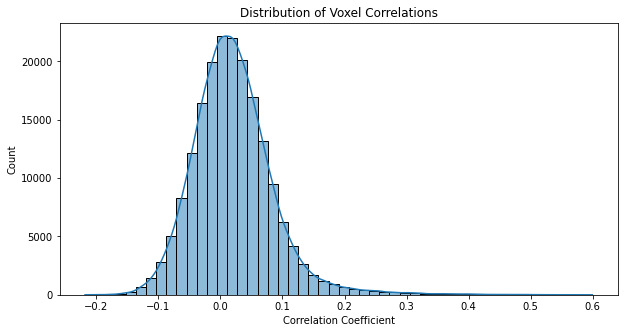

In [249]:
## Show the distribution of voxel correlations in a fig and log it to wandb as an image

fig = plt.figure(figsize=(10, 5))
sns.histplot(voxel_correlations, bins=50, kde=True)
plt.title("Distribution of Voxel Correlations")
plt.xlabel("Correlation Coefficient")

wandb.log({"Voxel Correlations": wandb.Image(fig)})
plt.show()








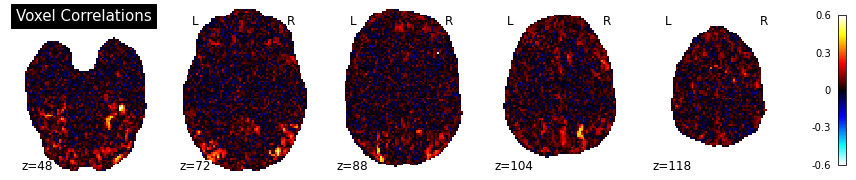

In [250]:
# ## Plot a map of the voxel correlations
voxel_correlation_map = masker.inverse_transform(voxel_correlations) ##Possibly to do
# Specify the colormap
cmap = "cold_hot"  # or any colormap you prefer

# Create a figure and capture the plot in it
# Save the plot as an image file
output_path = f"{target_dir}/voxel_correlation_map.png"
plot_stat_map(voxel_correlation_map, bg_img=None, title="Voxel Correlations",
              display_mode="z", cut_coords=5, colorbar=True, cmap="cold_hot")
plt.savefig(output_path, bbox_inches="tight")  # Save the plot

# Log the saved image to wandb
wandb.log({"Voxel Correlations new": wandb.Image(output_path)})



In [251]:
top_N= 10000
top_voxels = np.argsort(voxel_correlations)[::-1][:top_N]

top_voxel_correlations = voxel_correlations[top_voxels]

#print min of max correlation of top voxels
print("Minimum of maximum correlation of top voxels:", np.min(top_voxel_correlations))
print("Maximum of maximum correlation of top voxels:", np.max(top_voxel_correlations))

Minimum of maximum correlation of top voxels: 0.12445433168297795
Maximum of maximum correlation of top voxels: 0.5992789959699657


In [252]:
## Select the top fMRI voxels based on the correlation with the predicted responses

train_fmri_top = fmri_train[:, top_voxels]
val_fmri_top = fmri_val[:, top_voxels]
test_fmri_top = fmri_test[:, top_voxels]



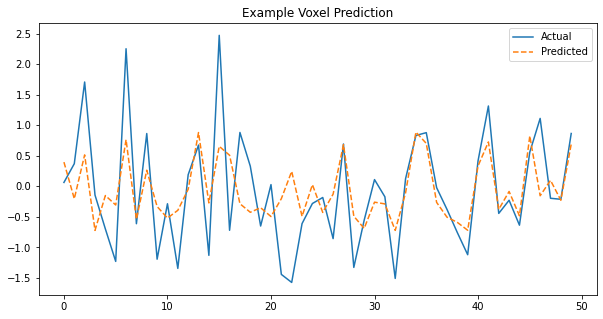

In [253]:
## plot an example of the predicted and actual fMRI responses for a voxel predicted with high accuracy

voxel_idx = top_voxels[0]
fig = plt.figure(figsize=(10, 5))
plt.plot(fmri_val[:50, voxel_idx], label="Actual")
plt.plot(val_predictions[:50, voxel_idx], '--',label="Predicted")
plt.title("Example Voxel Prediction")
plt.legend()

#log the figure to wandb
wandb.log({"Example Voxel Prediction": wandb.Image(fig)})


In [254]:
## Save the top fMRI voxels, voxel correlations and encoding model (ith pickle)
np.save(opj(target_dir, "train_fmri_top.npy"), train_fmri_top)
np.save(opj(target_dir, "val_fmri_top.npy"), val_fmri_top)
np.save(opj(target_dir, "test_fmri_top.npy"), test_fmri_top)

np.save(opj(target_dir, "top_voxels.npy"), top_voxels)
np.save(opj(target_dir, "top_voxel_correlations.npy"), top_voxel_correlations)

import pickle

with open(opj(target_dir, "encoding_model.pkl"), "wb") as f:
    pickle.dump(encoding_model, f)
    



## Perfom a simple baseline with a Ridge brain to image features + kNN to retrieve images

In [255]:
simple_decoding_model = RidgeCV(alphas=[1, 10, 100, 1e3, 1e4])
simple_decoding_model.fit(backend.asarray(train_fmri_top),train_image_features.cpu())

#Use the model to predict test set image features
test_predictions = simple_decoding_model.predict(backend.asarray(test_fmri_top))


/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/himalaya/ridge/_random_search.py:491: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 2244 < 10000). Using a linear kernel in himalaya.kernel_ridge.KernelRidgeCV or himalaya.kernel_ridge.solve_kernel_ridge_cv_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(


In [256]:
## Use a kNN to retrieve image indices based on the predicted image features

from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=10)
knn.fit(test_image_features.cpu().numpy())

_, indices = knn.kneighbors(test_predictions, n_neighbors=5)



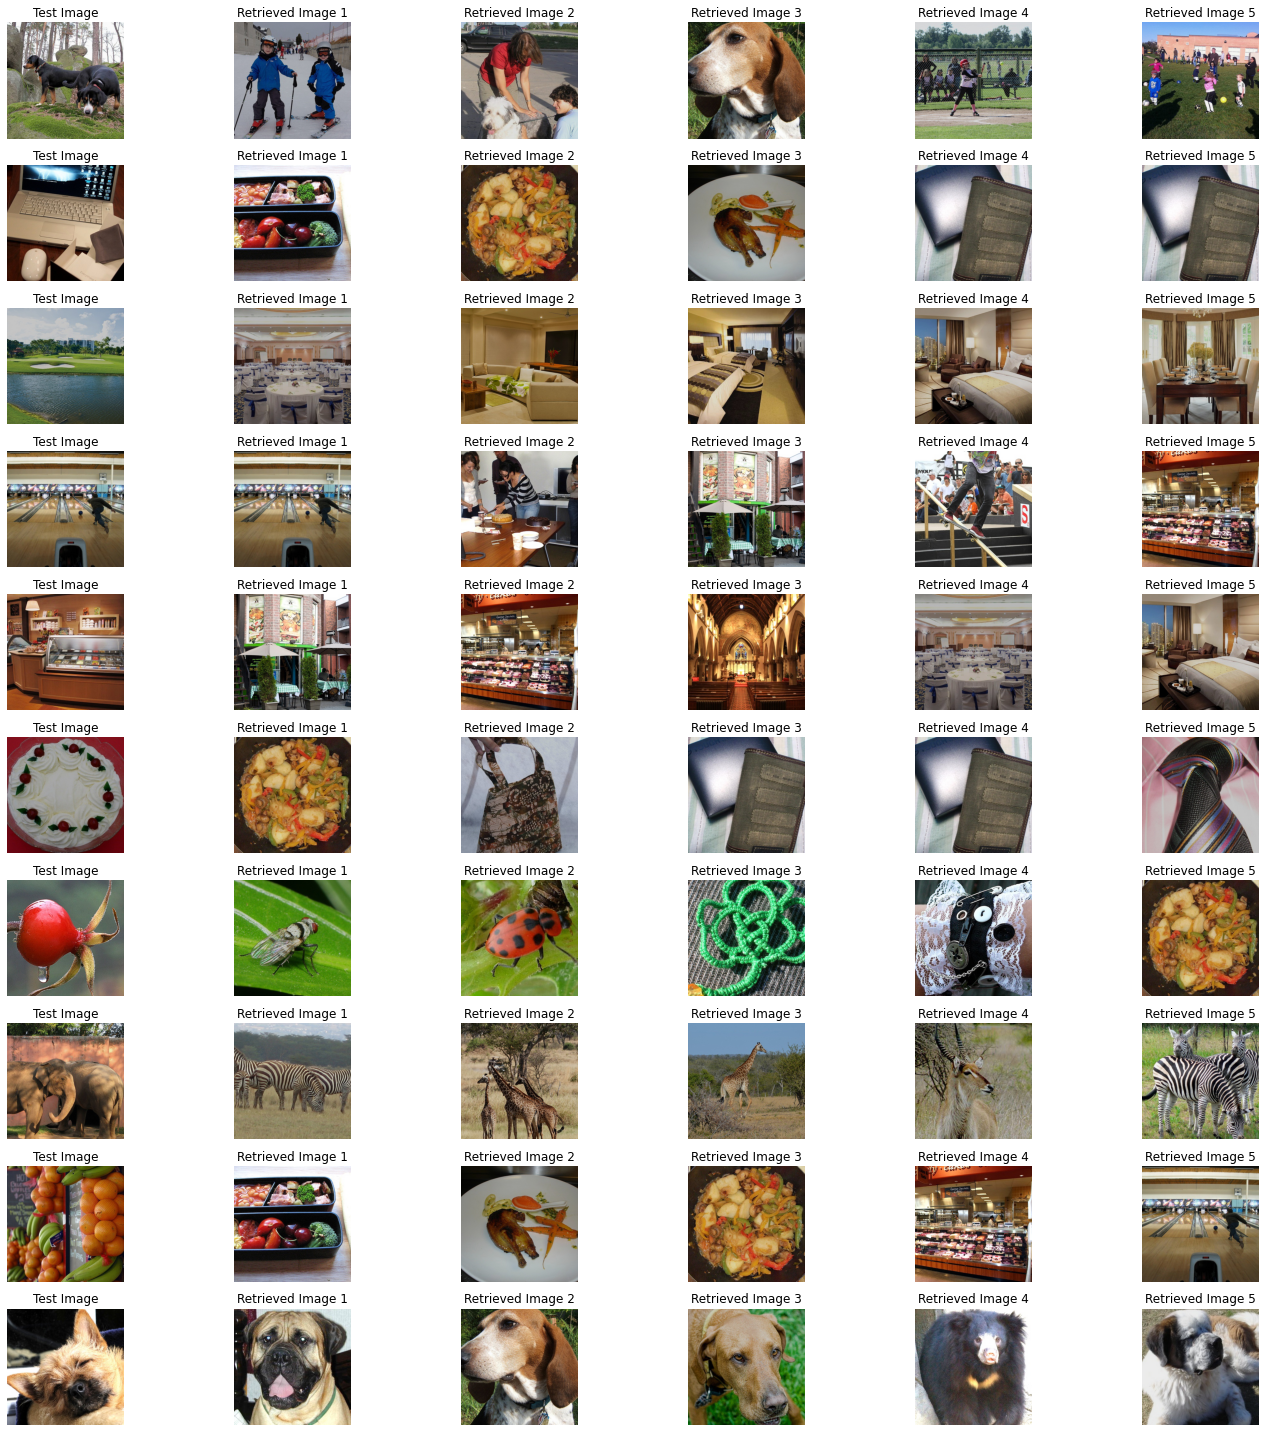

In [257]:
## Show the retrieved images for the first 10 test image

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(10, 6, 6 * i + 1)
    plt.imshow(img_test[i])
    plt.axis("off")
    plt.title("Test Image")

    for j in range(5):
        plt.subplot(10, 6, 6 * i + j + 2)
        plt.imshow(img_test[indices[i, j]])
        plt.axis("off")
        plt.title(f"Retrieved Image {j + 1}")

plt.tight_layout()

#save the figures to target_dir/figures and log it to wandb
os.makedirs(opj(target_dir, "figures"), exist_ok=True)
plt.savefig(opj(target_dir, "figures", "retrieved_images.png"))
wandb.log({"Retrieved Images": wandb.Image(opj(target_dir, "figures", "retrieved_images.png"))})

plt.show()


In [258]:
## Compute top1 and top5 accuracy

top1_correct = 0
top10_correct = 0


for i in range(len(test_predictions)):
    if i==indices[i][0]:
        top1_correct += 1
    if i in indices[i]:
        top10_correct += 1

top1_accuracy = 100*top1_correct / len(test_predictions)
top10_accuracy = 100*top10_correct / len(test_predictions)

print("Top-1 Accuracy:", top1_accuracy, "%")
print("Top-10 Accuracy:", top10_accuracy, "%")

## compute the baseline accuracy

baseline_top1_accuracy = 100*(1 / len(img_test))
baseline_top10_accuracy = 100*(10 / len(img_test))

print()

print("Baseline Top-1 Accuracy:", baseline_top1_accuracy, "%")
print("Baseline Top-5 Accuracy:", baseline_top10_accuracy, "%")
print()

print("Top-1 Accuracy over baseline:", top1_accuracy/baseline_top1_accuracy,)
print("Top-5 Accuracy over baseline:", top10_accuracy/baseline_top10_accuracy,)

## log everything to wandb
wandb.log({"Top-1 Accuracy": top1_accuracy})
wandb.log({"Top-5 Accuracy": top10_accuracy})
wandb.log({"Baseline Top-1 Accuracy": baseline_top1_accuracy})
wandb.log({"Baseline Top-5 Accuracy": baseline_top10_accuracy})
wandb.log({"Top-1 Accuracy over Baseline": top1_accuracy / baseline_top1_accuracy})
wandb.log({"Top-5 Accuracy over Baseline": top10_accuracy / baseline_top10_accuracy})


Top-1 Accuracy: 3.4261241970021414 %
Top-10 Accuracy: 13.9186295503212 %

Baseline Top-1 Accuracy: 0.044563279857397504 %
Baseline Top-5 Accuracy: 0.4456327985739751 %

Top-1 Accuracy over baseline: 76.88222698072805
Top-5 Accuracy over baseline: 31.23340471092077


In [259]:
## Compute the identification accuracy
def identification_accuracy_fast(P, T):
    n = P.shape[0]
    
    # Compute the mean and standard deviation for each vector in P and T
    P_mean = np.mean(P, axis=1, keepdims=True)
    T_mean = np.mean(T, axis=1, keepdims=True)
    P_std = np.std(P, axis=1, keepdims=True)
    T_std = np.std(T, axis=1, keepdims=True)
    
    # Normalize P and T
    P_normalized = (P - P_mean) / P_std
    T_normalized = (T - T_mean) / T_std
    
    # Compute the correlation matrix using matrix multiplication
    C = np.dot(P_normalized, T_normalized.T) / P.shape[1]

    # Compute identification accuracy per prediction
    id_acc = np.zeros(n)
    for i in tqdm.trange(n):
        id_acc[i] = (C[i, i] >= C[i]).sum()  
        id_acc[i] = id_acc[i] / (n - 1)
    
    # Average identification accuracy
    overall_id_acc = np.mean(id_acc)
    
    return overall_id_acc

In [260]:
id_acc = identification_accuracy_fast(test_predictions.numpy(), test_image_features.cpu().numpy())

print("Identification Accuracy:", id_acc)

#log to wandb

wandb.log({"Identification Accuracy": id_acc})


100%|██████████| 467/467 [00:00<00:00, 73407.79it/s]

Identification Accuracy: 0.9160608761981786


In [261]:
print("All done!", subj)

All done! CSI4
